In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set(style="whitegrid")
import os
import glob as gb
import cv2

import tensorflow as tf
from keras.layers import Dropout , MaxPool2D , BatchNormalization , Conv2D
from keras import Sequential , layers

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Open Folder

In [3]:
trainpath = r"D:\flower_photos (2)\flower_photos"

for folder in os.listdir(trainpath):
    folder_path = os.path.join(trainpath, folder)  
    files = gb.glob(pathname=os.path.join(folder_path, "*.jpg"))  
    print(f"For training data, found {len(files)} files in folder {folder}")


For training data, found 633 files in folder daisy
For training data, found 898 files in folder dandelion
For training data, found 641 files in folder roses
For training data, found 699 files in folder sunflowers


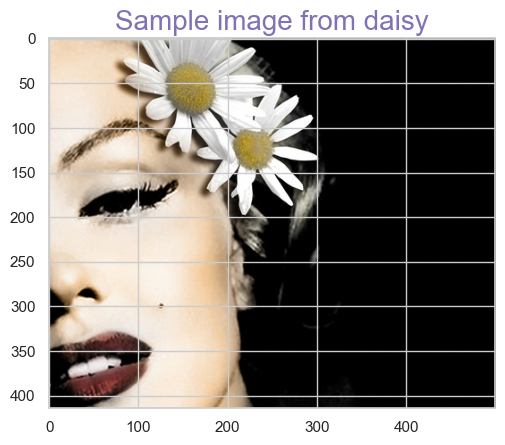

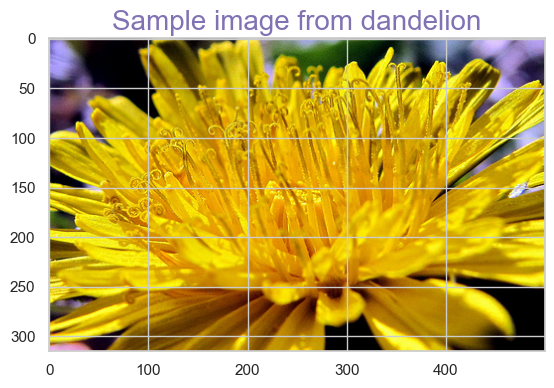

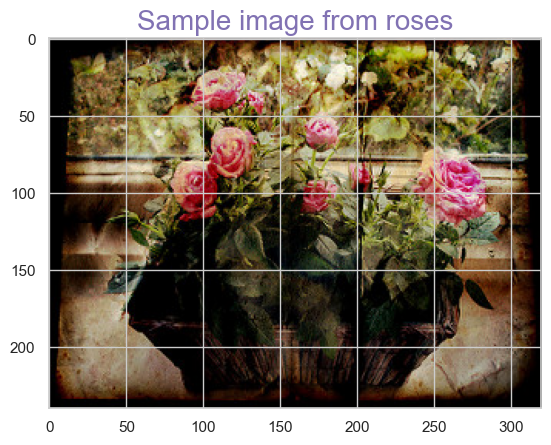

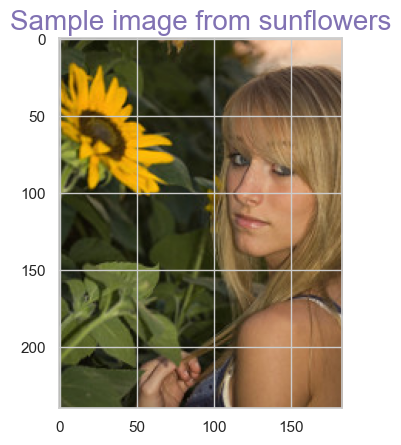

In [4]:
# Display image in all folder
for folder in os.listdir(trainpath):
    folder_path = os.path.join(trainpath, folder)
    files = os.listdir(folder_path)
    random_image = random.choice(files)
    img_path = os.path.join(folder_path, random_image)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"Sample image from {folder}" , fontsize=20 , color="m")
    plt.show()


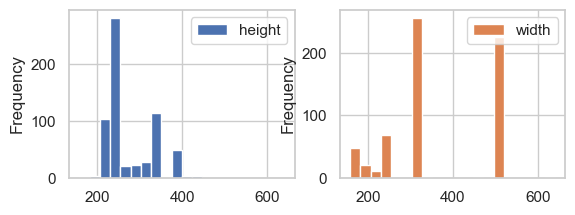

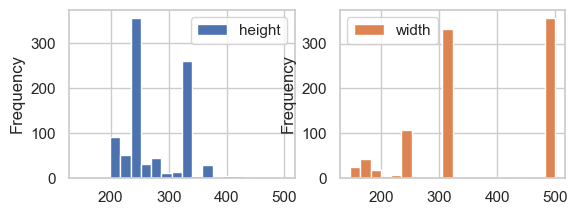

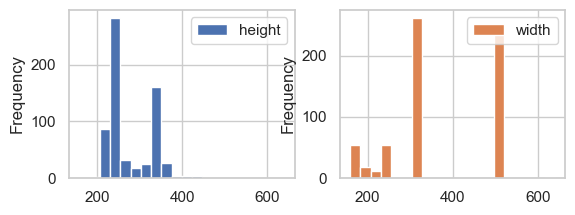

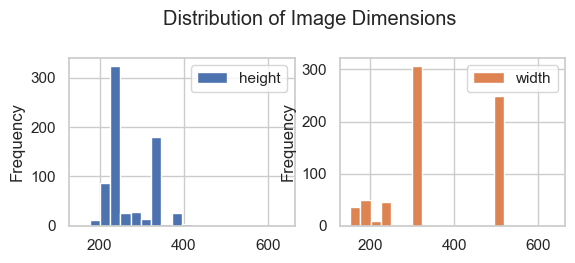

In [5]:
dimensions = []
for folder in os.listdir(trainpath):
    folder_path = os.path.join(trainpath, folder)
    for img_path in gb.glob(os.path.join(folder_path, "*.jpg")):
        img = plt.imread(img_path)  
        dimensions.append((folder, img.shape[0], img.shape[1]))  #extract the height and width of the image.
                                                                  
df = pd.DataFrame(dimensions, columns=["folder", "height", "width"])
df.groupby("folder").plot(kind="hist", bins=20, subplots=True, layout=(2, 2))
plt.suptitle("Distribution of Image Dimensions")
plt.show()


In [6]:
print(f"Display image before to convert size == {img.shape}")

Display image before to convert size == (240, 159, 3)


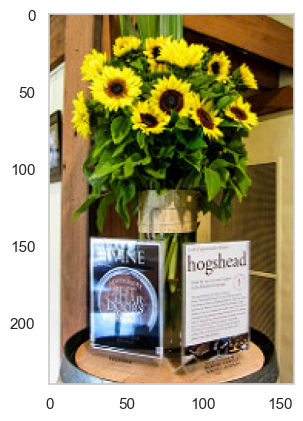

In [7]:
plt.imshow(img , cmap="gray")
plt.grid(False)
plt.show()

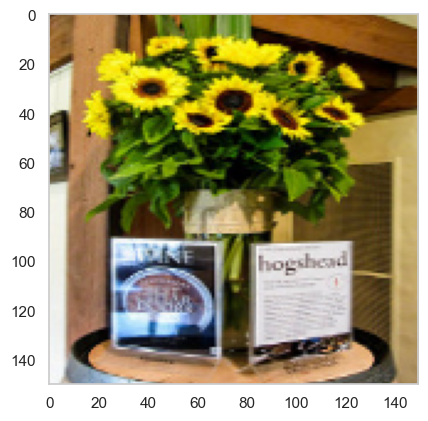

In [8]:
new_size = 150

new_img = cv2.resize(img , (new_size , new_size))
plt.imshow(new_img , cmap="gray")
plt.grid(False)
plt.show()

In [9]:
print(f"Display image After to convert size == {new_img.shape}")

Display image After to convert size == (150, 150, 3)


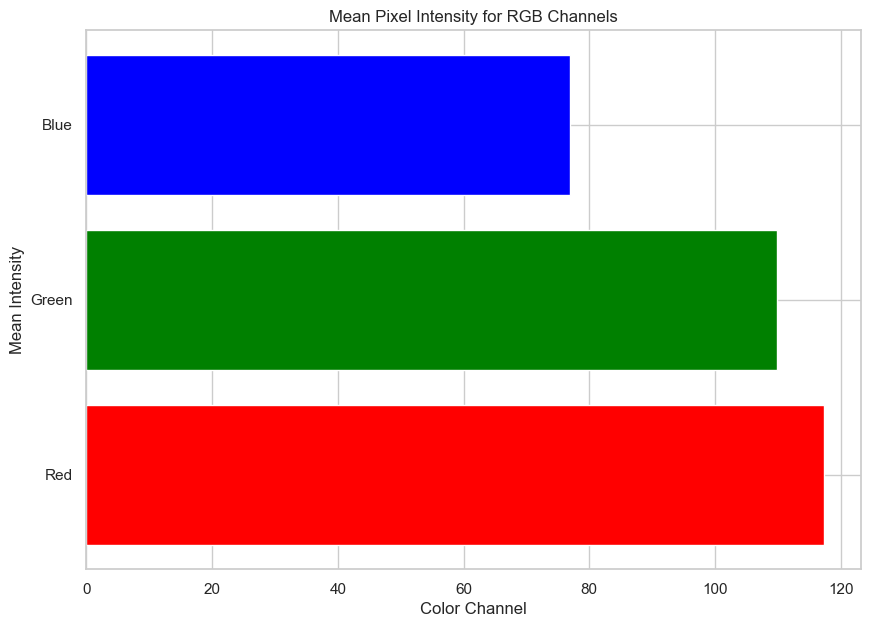

In [10]:
# Load all training images
train_images = np.array([plt.imread(img_path) for img_path in gb.glob(os.path.join(trainpath, '*/*.jpg'))])

# Resize images to 150x150
new_size = 150
resized_images = np.array([cv2.resize(img, (new_size, new_size)) for img in train_images])

# Calculate mean pixel intensity for each channel
mean_red = np.mean(resized_images[:, :, :, 0])  # 117.40439995355858
mean_green = np.mean(resized_images[:, :, :, 1]) # 109.90152213320948
mean_blue = np.mean(resized_images[:, :, :, 2])  # 76.99060310383528

# Create the bar chart
plt.figure(figsize=(10, 7))
plt.barh(['Red', 'Green', 'Blue'], [mean_red, mean_green, mean_blue], color=['red', 'green', 'blue'])
plt.title('Mean Pixel Intensity for RGB Channels')
plt.xlabel('Color Channel')
plt.ylabel('Mean Intensity')
plt.show()


In [11]:
# shape train 
train_images.shape

(2871,)

In [12]:
# shape after resize

resized_images.shape

(2871, 150, 150, 3)

In [13]:
# Normalization 
resized_images = resized_images /255


In [14]:
def folder_to_label(folder):
    """Maps folder names to numeric labels."""
    label_map = {"daisy": 0, "dandelion": 1, "roses": 2, "sunflowers": 3}  # Adjust as needed
    return label_map[folder]

# Gather all resized images and labels
resized_images = []
labels = []
for folder in os.listdir(trainpath):
    folder_path = os.path.join(trainpath, folder)
    label = folder_to_label(folder)  # Map folder name to numeric label
    for img_path in gb.glob(os.path.join(folder_path, "*.jpg")):
        img = plt.imread(img_path)
        resized_img = cv2.resize(img, (new_size, new_size))
        resized_images.append(resized_img)
        labels.append(label)

# Convert resized images and labels to NumPy arrays
resized_images = np.array(resized_images)
labels = np.array(labels)

## Model 

In [16]:
model = Sequential([
    layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1),
                  padding="same", activation="relu",
                  input_shape=(new_size, new_size, 3)), # Add channel dimension
    
    layers.BatchNormalization(),
    
    layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    
    layers.Dropout(0.3),
    
    layers.Conv2D(filters=64, kernel_size=(5, 5),
                  strides=(1, 1), padding="same", activation="relu"),
    
    layers.BatchNormalization(),
    
    layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    
    layers.Dropout(0.4),
    
    layers.Flatten(),
    
    layers.Dense(1000, activation="relu"),
    
    layers.Dense(4, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 batch_normalization_2 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 batch_normalization_3 (Bat  (None, 75, 75, 64)       

In [20]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [22]:
history = model.fit(resized_images, labels, epochs=7)
history

Epoch 1/7
90/90 [==============================] - 119s 1s/step - loss: 8.0838 - accuracy: 0.5051
Epoch 2/7
90/90 [==============================] - 120s 1s/step - loss: 0.8662 - accuracy: 0.6573
Epoch 3/7
90/90 [==============================] - 120s 1s/step - loss: 0.6564 - accuracy: 0.7457
Epoch 4/7
90/90 [==============================] - 120s 1s/step - loss: 0.5334 - accuracy: 0.7945
Epoch 5/7
90/90 [==============================] - 123s 1s/step - loss: 0.3727 - accuracy: 0.8631
Epoch 6/7
90/90 [==============================] - 120s 1s/step - loss: 0.2810 - accuracy: 0.8906
Epoch 7/7
90/90 [==============================] - 120s 1s/step - loss: 0.2457 - accuracy: 0.9126


In [23]:
loss ,accuracy  = model.evaluate(resized_images, labels)
print("loss is == ", loss)
print("accuracy is == ", accuracy)


90/90 [==============================] - 14s 155ms/step - loss: 0.3561 - accuracy: 0.8972
loss is ==  0.356134295463562
accuracy is ==  0.8972483277320862


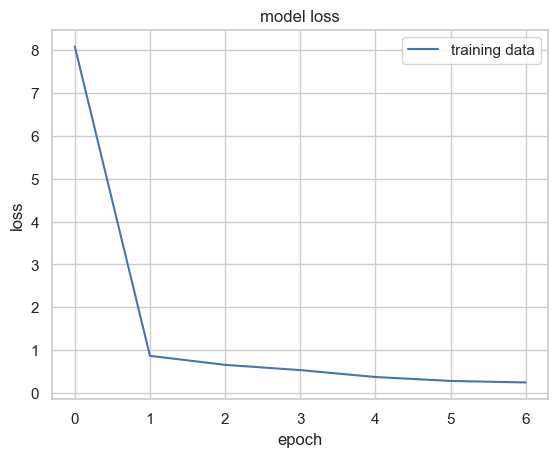

In [24]:
plt.plot(history.history["loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['training data', 'validation data'], loc = 'upper right')

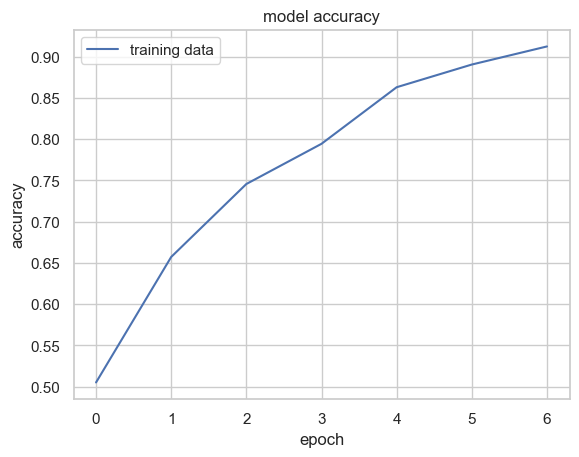

In [25]:
plt.plot(history.history["accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['training data', 'validation data'], loc = 'upper left')

# END

# BY : SAYED ALI